In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Reading in & Formatting Price Data
The .csv read from contains the price of [bitcoin](https://bitcoin.org/en/) from 2015-02-01 to 2018-04-21.

In [2]:
prices_raw = pd.read_csv('data/price_data_final.csv', infer_datetime_format=True)
p = prices_raw['price']
print(p.head(2))
print(p.tail(2))

0    226.3959
1    237.5409
Name: price, dtype: float64
1174    8863.5025
1175    8917.5963
Name: price, dtype: float64


### Reading in & Formatting Quantified Sentiment
The .csv we read from here contains daily sentiment scores from 2015-02-01 to 2018-04-21 for the title of every post in the [Bitcoin subreddit](https://www.reddit.com/r/Bitcoin/), an online Bitcoin community.

There seems to be *a lot* of noise in the form of 0's (neutral sentiment). **How can this effectively be handled?**

For now, I will take the daily average.

In [3]:
sentiment_raw = pd.read_csv('data/reddit_sentiment_data_final.csv', infer_datetime_format=True)
s = sentiment_raw.mean(axis=1)
print(s.head(2))
print(s.tail(2))

0    0.068356
1    0.068356
dtype: float64
1174    0.0
1175    0.0
dtype: float64


In [4]:
count = 0
for i in sentiment_raw.drop('Unnamed: 0', axis=1).values:
    for v in i:
        if v == 0:
            count += 1
print(count)

19572


### Final Data Formatting

In [5]:
# create the "today's price" feature
prices = prices_raw.set_index('Unnamed: 0')
prices = prices.reset_index(drop=True)
print(prices.head(3))
print(prices.tail(3))

      price
0  226.3959
1  237.5409
2  226.9566
          price
1173  8273.7413
1174  8863.5025
1175  8917.5963


In [6]:
# create "today's price - yesterday's price" feature
diff = []
for n in range(0,len(prices)):
    diff.append(prices.iloc[n] - prices.iloc[n-1])
diff = pd.DataFrame(diff)
print(diff.head(3))
print(diff.tail(3))

       price
0 -8691.2004
1    11.1450
2   -10.5843
         price
1173  110.0513
1174  589.7612
1175   54.0938


In [7]:
# create "tomorrow's price" label (for regression)
label = pd.DataFrame(prices.drop(0)).reset_index(drop=True)
print(label.head(3))
print(label.tail(3))

      price
0  237.5409
1  226.9566
2  226.7291
          price
1172  8273.7413
1173  8863.5025
1174  8917.5963


In [8]:
# create binary "today minus yesterday up or down" feature
upOrDown = pd.DataFrame([1 if d > 0 else 0 for d in diff.values])
print(upOrDown.head(3))
print(upOrDown.tail(3))

   0
0  0
1  1
2  0
      0
1173  1
1174  1
1175  1


In [9]:
# create "tomorrow minus today up or down" label for classification
updownLabel = upOrDown.drop(0).reset_index(drop=True)
print(updownLabel.head(3))
print(updownLabel.tail(3))

   0
0  1
1  0
2  0
      0
1172  1
1173  1
1174  1


In [10]:
# create + or - sentiment feature
posnegSent = pd.DataFrame([1 if d > 0 else 0 for d in s.values])
print(posnegSent.head(3))
print(posnegSent.tail(3))

   0
0  1
1  1
2  1
      0
1173  1
1174  0
1175  0


In [11]:
# resizing
prices = prices.drop(1175)
diff = diff.drop(1175)
upOrDown = upOrDown.drop(1175)
s = s.drop(1175)
posnegSent = posnegSent.drop(1175)

In [12]:
# Bringing it all together
datas = pd.concat([prices, diff, s, posnegSent, label, upOrDown, updownLabel], axis=1)
datas.columns = ['price(t)', 'p(t) - p(t-1)','s(t)', 'sentPosNeg', 'p(t+1)',
                 'p(t) - p(t-1) > 0', 'p(t+1) - p(t) > 0']
datas = datas.drop(0)
datas.head(10)

,price(t),p(t) - p(t-1),s(t),sentPosNeg,p(t+1),p(t) - p(t-1) > 0,p(t+1) - p(t) > 0
1,237.5409,11.1450,0.068356,1,226.9566,1,0
2,226.9566,-10.5843,0.068356,1,226.7291,0,0
3,226.7291,-0.2275,0.028507,1,216.7714,0,0
4,216.7714,-9.9577,0.021100,1,222.4823,0,1
5,222.4823,5.7109,0.061841,1,227.3275,1,1
6,227.3275,4.8452,0.053797,1,222.8677,1,0
7,222.8677,-4.4598,0.090851,1,220.1743,0,0
8,220.1743,-2.6934,0.112266,1,220.0829,0,0
9,220.0829,-0.0914,0.112266,1,219.4922,0,0
10,219.4922,-0.5907,0.087424,1,221.8513,0,1


### ...Let's try KNN
#### This first section uses KNeighborsRegressor to predict price. 

In [13]:
from sklearn.neighbors import KNeighborsRegressor

In [14]:
knnReg = KNeighborsRegressor(n_neighbors=2)
X = datas[['price(t)', 's(t)']]
Y = datas['p(t+1)']
knnReg.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [15]:
x = list(range(1, 1175))
y = []
for n in x:
    y.append(knnReg.predict(X[n-1:n]))

Text(0.5,1,'KNN Regressor Predicting BTC Price')

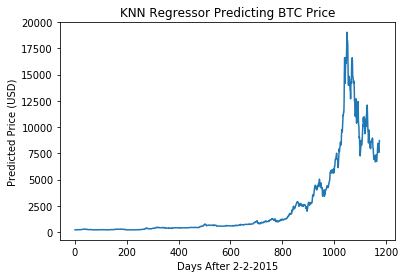

In [16]:
plt.plot(x,y)
plt.xlabel('Days After 2-2-2015')
plt.ylabel('Predicted Price (USD)')
plt.title('KNN Regressor Predicting BTC Price')

so thats knnRegressor... not tweaked, but it followed the path so we know the model does its purpose. 

knnClassifier comin' up next.

Text(0.5,1,'Price of BTC, Feb 2015 - April 2018')

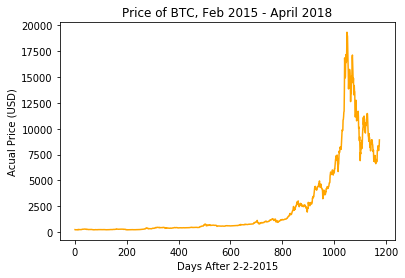

In [17]:
plt.plot(x,p.drop(0).drop(1174), color='orange')
plt.xlabel('Days After 2-2-2015')
plt.ylabel('Acual Price (USD)')
plt.title('Price of BTC, Feb 2015 - April 2018')

In [18]:
# Some evaluation?
from sklearn.model_selection import cross_val_score

In [19]:
np.mean(cross_val_score(knnReg, X[1000:1175], Y[1000:1175]))
# restricting the training to recent data ^^^

0.8645989646637181

#### This second section uses KNeighborsClassifier to predict whether the price will go up or down.

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
X = datas[['sentPosNeg', 'p(t) - p(t-1) > 0']]
Y = datas[['p(t+1) - p(t) > 0']]
knnClass = KNeighborsClassifier(n_neighbors=3)
knnClass.fit(X[1000:1175],Y[1000:1175])

/home/brandon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [22]:
np.mean(cross_val_score(knnClass, X[1000:1175], Y[1000:1175]))

/home/brandon/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/brandon/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/brandon/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


0.5566902840580898

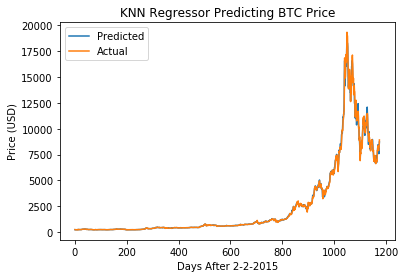

In [33]:
plt.plot(x,y,x,p.drop(0).drop(1174))
plt.xlabel('Days After 2-2-2015')
plt.ylabel('Price (USD)')
plt.title('KNN Regressor Predicting BTC Price')
plt.legend(('Predicted', 'Actual'))